In [13]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [14]:
def plt2l(ax, x, y_list, label_list, title='', fontsize=10, 
          yrange=[40., 85.], xrange=[-6, 6], xlabel=True, 
          ylabel='Cloud cover (%)', legend=True):
    for y, label in zip(y_list, label_list):
        ax.plot(x, y, label=label)

    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    if xlabel:
        ax.set_xlabel('Distance from ice edge \n ($\\degree$ latitude)', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.axvline(x=0., color='black', lw=0.5, linestyle='--')
    if legend:
        ax.legend(loc='best', fontsize=0.8 * fontsize)

Slope: -4.271
Intercept: 62.512
R²: 0.899
P-value: 0.004
Std. Error: 0.714


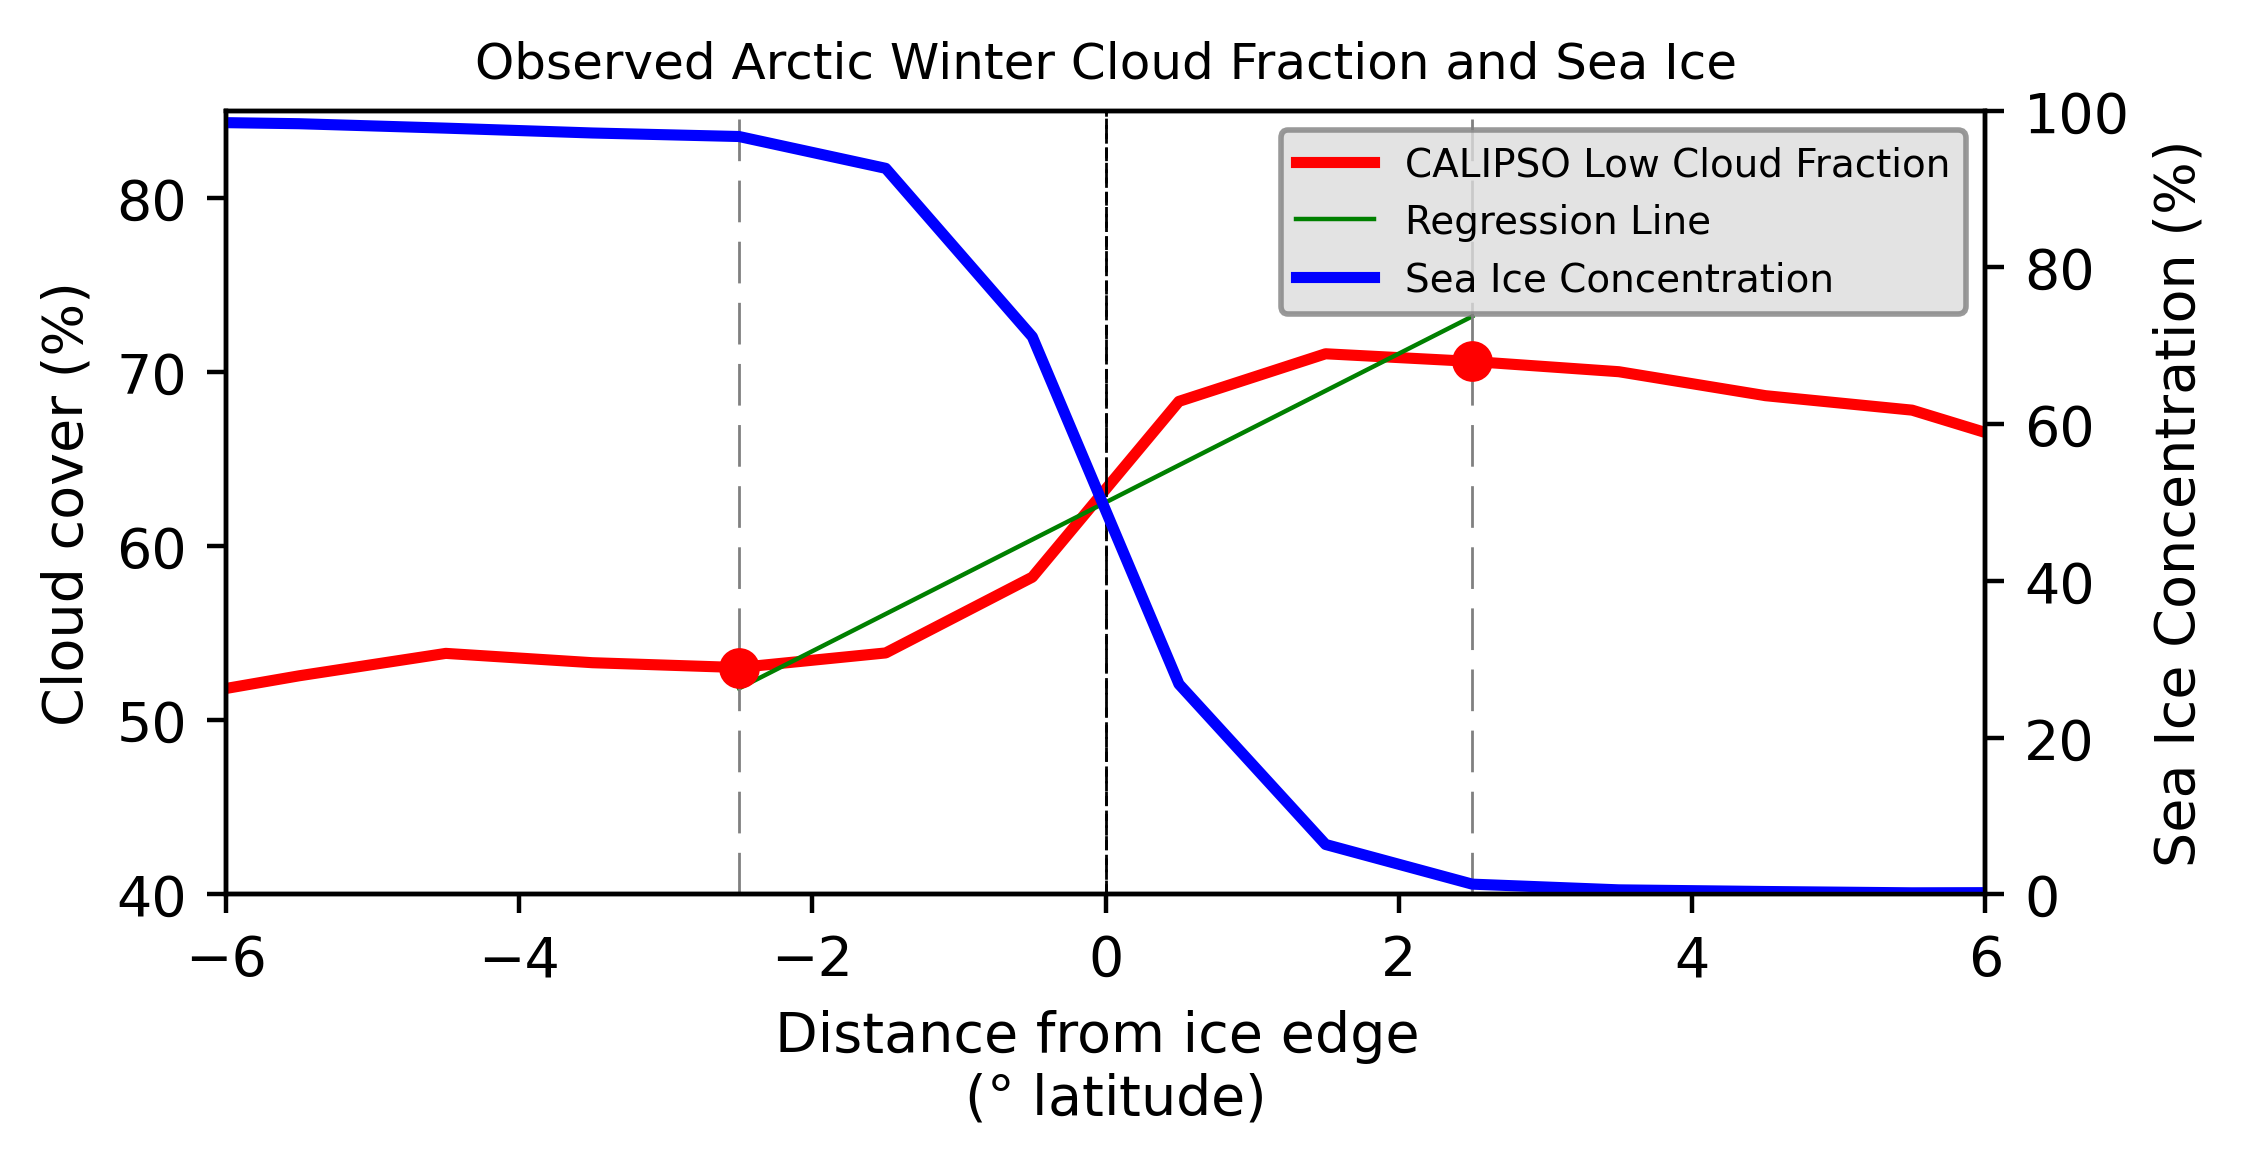

In [17]:
obs_file = "/home/rcostell/Projects/CMIP6_Intercomparison/Codes_Before_Github_Transfer/Binned_Observed_2D_CF.nc"
obs_ds = xr.open_dataset(obs_file)
obs_ds = obs_ds.groupby("time.season").mean()  # Average by season

# === Select DJF (NH winter) ===
obs_x = obs_ds.distance.values
obs_y = obs_ds.cllcalipso.sel(season='DJF').values * 100  # Convert to %
ice_y = obs_ds.seaice_conc.sel(season='DJF').values * 100 if "seaice_conc" in obs_ds else None

# === Filter by range around ice edge ===
mask_all = np.logical_and(obs_x >= -6.5, obs_x <= 6.5)
obs_x_filtered = obs_x[mask_all]
obs_y_filtered = obs_y[mask_all]
ice_y_filtered = ice_y[mask_all] if ice_y is not None else None

# === Regression subset (within ±2.5° of ice edge) ===
mask_reg = np.logical_and(obs_x_filtered >= -2.5, obs_x_filtered <= 2.5)
obs_x_regression = obs_x_filtered[mask_reg]
obs_y_regression = obs_y_filtered[mask_reg]

# === Compute linear regression ===
slope, intercept, r_value, p_value, std_err = linregress(obs_x_regression, obs_y_regression)
regression_line_observed = slope * obs_x_regression + intercept

print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")
print(f"R²: {r_value**2:.3f}")
print(f"P-value: {p_value:.3f}")
print(f"Std. Error: {std_err:.3f}")

# === Define plotting function (2-line plot) ===
def plt2l(ax, x, y_list, label_list, title='', fontsize=10, yrange=[40., 85.],
          xrange=[-6, 6], xlabel=True, ylabel='Cloud cover (%)', legend=True, color=None):
    for y, label in zip(y_list, label_list):
        ax.plot(x, y, label=label, linewidth=2, color=color)
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    if xlabel:
        ax.set_xlabel('Distance from ice edge \n ($\\degree$ latitude)', fontsize=fontsize)
    ax.axvline(x=0., color='black', lw=0.5, linestyle='--')
    if legend:
        ax.legend(loc='best', fontsize=0.8 * fontsize)
    ax.set_title(title, fontsize=fontsize)

# === Create regression + sea ice figure ===
myfontsize = 10
fig, ax = plt.subplots(figsize=(5.5, 2.8), dpi=400)  # Wider and slightly shorter

# Plot observed cloud fraction (red)
plt2l(ax, -obs_x_filtered, [obs_y_filtered],
      ['CALIPSO Low Cloud Fraction'],
      legend=False, color='red')

ax.plot(-obs_x_regression, regression_line_observed,
        color='green', linewidth=0.8, label='Regression Line')

# === Secondary y-axis for sea ice concentration ===
if ice_y_filtered is not None:
    ax_seaice = ax.twinx()
    ax_seaice.set_ylabel('Sea Ice Concentration (%)', fontsize=myfontsize)
    ax_seaice.plot(-obs_x_filtered, ice_y_filtered, color='blue', linewidth=2, label='Sea Ice Concentration')
    ax_seaice.set_ylim(0, 100)
else:
    ax_seaice = None

# === Add vertical reference lines ===
ax.axvline(x=0., color='black', lw=0.5, linestyle=(0, (5, 3)))
ax.axvline(x=-2.5, color='gray', lw=0.5, linestyle=(0, (15, 7)))
ax.axvline(x=2.5, color='gray', lw=0.5, linestyle=(0, (15, 7)))

# === Mark points at -2.5° and 2.5° ===
idx_neg_2_5 = np.argmin(np.abs(-obs_x_filtered + 2.5))
idx_pos_2_5 = np.argmin(np.abs(-obs_x_filtered - 2.5))
ax.scatter([-2.5], [obs_y_filtered[idx_neg_2_5]], color='red', s=40, zorder=5)
ax.scatter([2.5], [obs_y_filtered[idx_pos_2_5]], color='red', s=40, zorder=5)

# === Combined legend and title ===
fig.legend(
    loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes,
    fontsize=7, frameon=True, facecolor='gainsboro', edgecolor='gray', handlelength=2)

plt.title('Observed Arctic Winter Cloud Fraction and Sea Ice', fontsize=9)
plt.tight_layout(pad=0.3)

# === Save and show ===
plt.savefig('Fig_1_Regression.png', dpi=400, bbox_inches='tight')
plt.show()